# Exploration Data Analysis (Part II)

### Author: Louis Wong

In [2]:
from pyspark.sql import SparkSession
from dotenv import load_dotenv
import os

# Load credentials
load_dotenv()
minio_user = os.getenv("MINIO_ROOT_USER")
minio_pass = os.getenv("MINIO_ROOT_PASSWORD")

s3_endpoint = "http://host.docker.internal:9000"

# Create SparkSession with MinIO S3 config
spark = (
    SparkSession.builder.appName("SparkJob")
    .config("spark.hadoop.fs.s3a.endpoint", s3_endpoint)
    .config("spark.hadoop.fs.s3a.access.key", minio_user)
    .config("spark.hadoop.fs.s3a.secret.key", minio_pass)
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") # MinIO does not use SSL by default
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .getOrCreate()
)

# MinIO requires setting credentials provider explicitly
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")

# Show Spark version
print("Spark Version:", spark.version)
print("Hadoop Version:", spark._jsc.version())
print("Alive:", not spark.sparkContext._jsc.sc().isStopped())

# Define the silver layer location
silver_bucket = "silver-data"
silver_key    = "healthcare-dataset-stroke-data"
silver_path   = f"s3a://{silver_bucket}/{silver_key}"

# Load delta lake data
df = spark.read.format("delta").load(silver_path)

# Convert to Pandas for easier EDA
df = df.toPandas()

df.info()
df.head()

Spark Version: 3.5.4-amzn-0
Hadoop Version: 3.5.4-amzn-0
Alive: True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   admission_date        5109 non-null   object 
 1   gender                5109 non-null   object 
 2   age                   5109 non-null   int32  
 3   hypertension          5109 non-null   int32  
 4   heart_disease         5109 non-null   int32  
 5   ever_married          5109 non-null   int32  
 6   work_type             5109 non-null   object 
 7   residence_type        5109 non-null   object 
 8   avg_glucose_level     5109 non-null   float64
 9   smoking_status        5109 non-null   object 
 10  stroke                5109 non-null   int32  
 11  bmi                   5109 non-null   float64
 12  admission_year_month  5109 non-null   object 
dtypes: float64(2), int32(5), object(6)
memory usage: 419.2+ KB


,admission_date,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,smoking_status,stroke,bmi,admission_year_month
0,2025-02-06,Female,81,1,0,1,Private,Rural,80.43,never smoked,1,29.70,2025-02
1,2025-02-20,Male,57,0,1,0,Govt_job,Urban,217.08,Unknown,1,32.42,2025-02
2,2025-02-07,Female,52,1,0,1,Self-employed,Urban,233.29,never smoked,1,48.90,2025-02
3,2025-02-18,Male,82,0,1,1,Private,Rural,208.30,Unknown,1,32.50,2025-02
4,2025-02-17,Female,72,1,0,1,Private,Rural,74.63,formerly smoked,1,23.10,2025-02


## Class & Label Imbalance

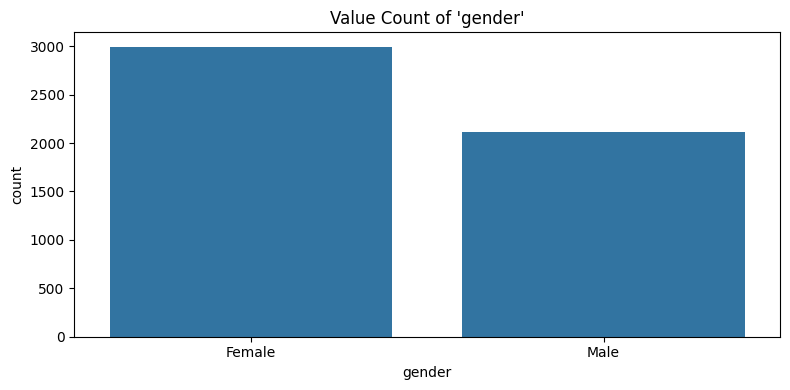

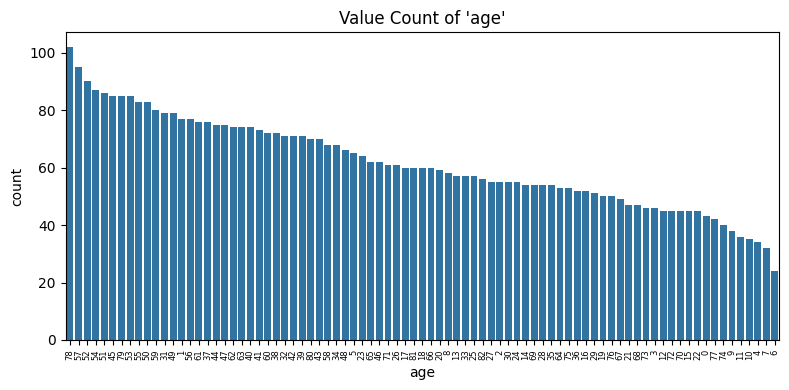

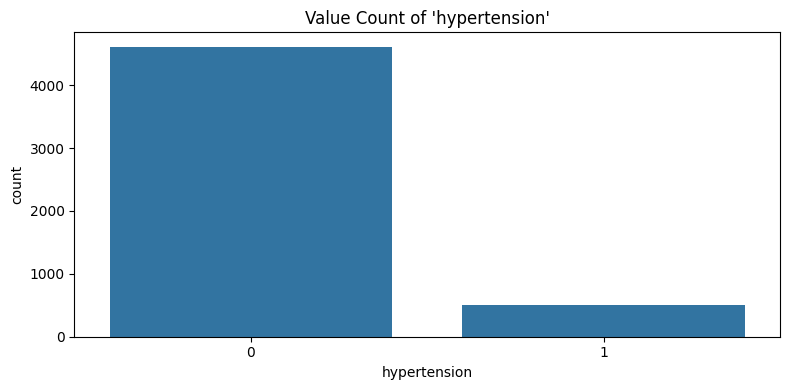

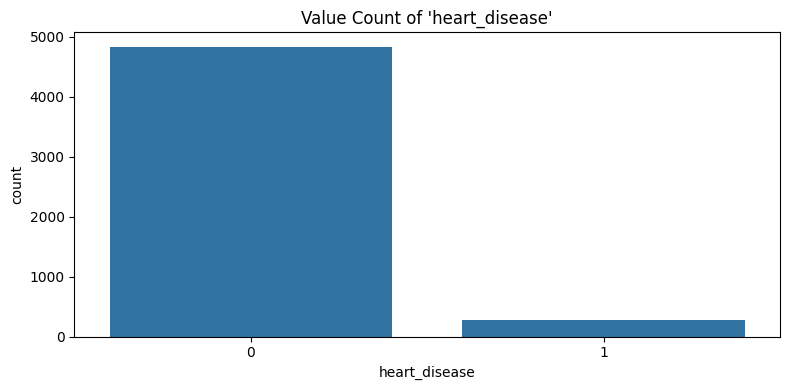

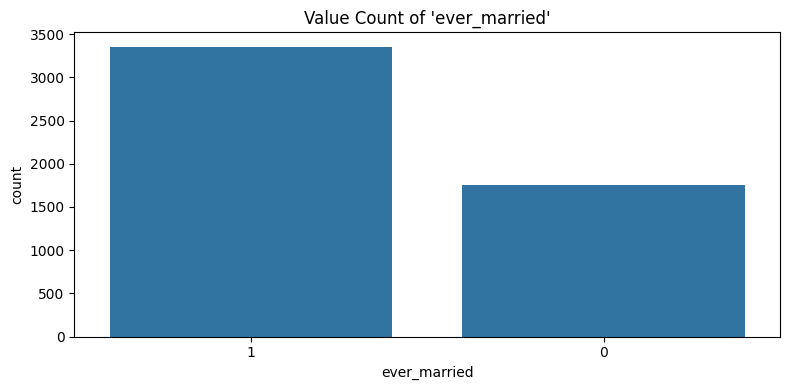

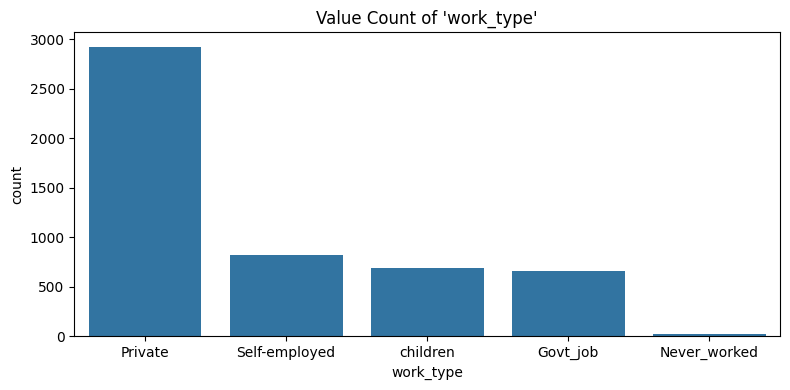

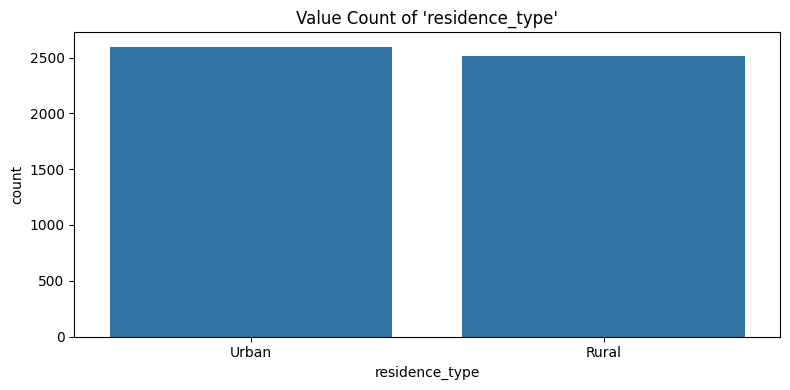

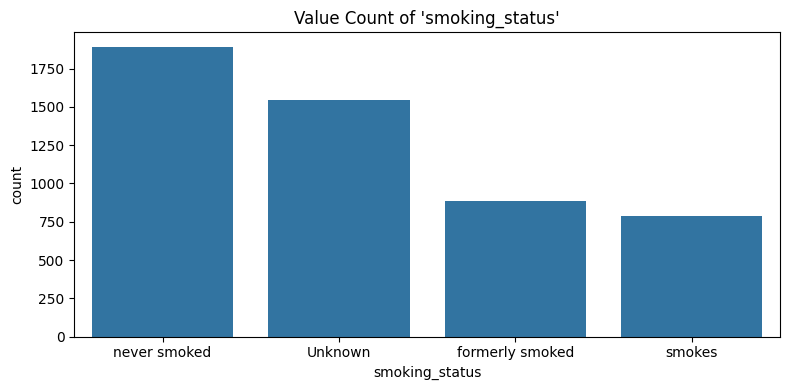

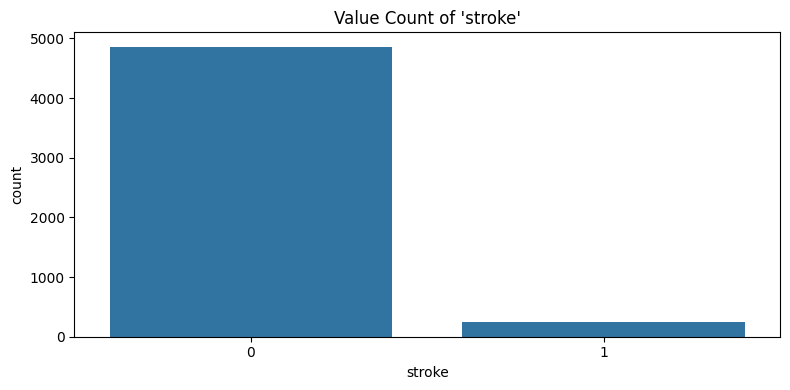

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop date column
df = df.drop(columns=["admission_date", "admission_year_month"])

# Check for class imbalance
cat_cols = df.select_dtypes(include=["object", "int32"]).columns 

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Value Count of '{col}'")
    if col == "age":
        plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()

As you can see, the predictive label for stroke is highly imbalanced. However, we will not address this issue here, since we want to keep the gold data layer in its original form as the source of truth. Instead, we will handle the imbalance later during preprocessing by applying resampling techniques.

## Distribution Skewness & Outliers

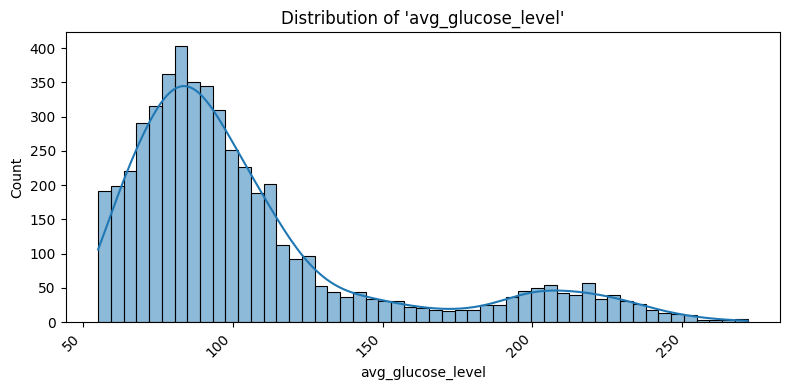

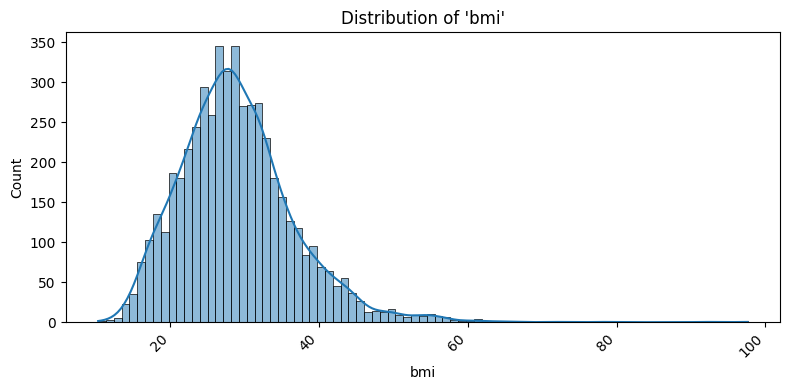

In [4]:
# Let's check for outliers in numerical columns
num_cols = df.select_dtypes(include=["float64"]).columns

# Skewness check
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of '{col}'")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

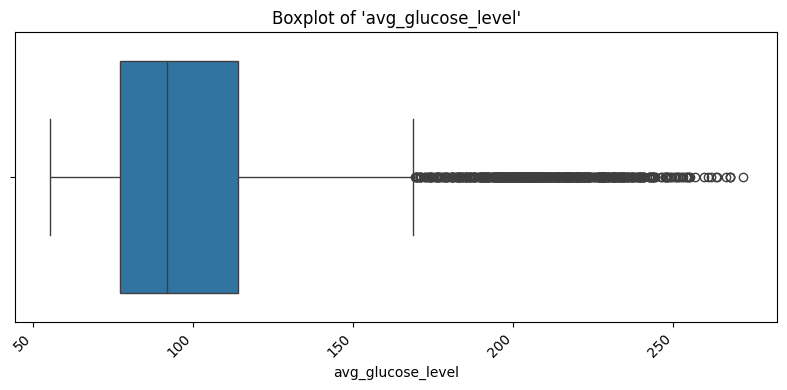

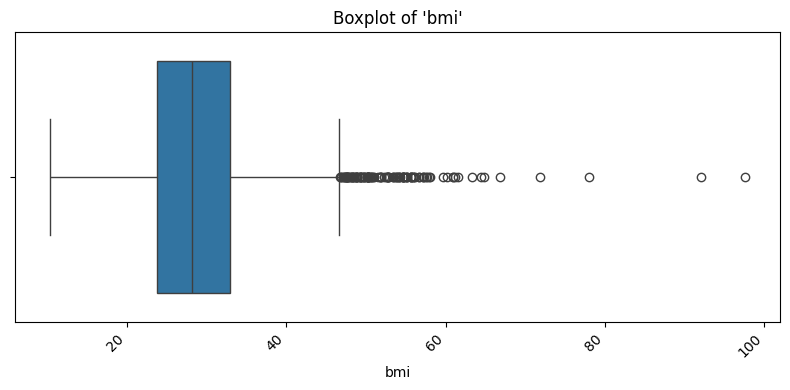

In [5]:
# Droping other in gender column as it is very small
df = df[df['gender'] != 'Other']

# Let's check for outliers in numerical columns
num_cols = df.select_dtypes(include=["float64"]).columns

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of '{col}'")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Average glucose level and BMI are likely critical predictors of stroke. The distribution of average glucose level appears bimodal but is primarily right-skewed, while BMI follows a roughly normal distribution with a few clear outliers.

We will be applying log transformation to reduce skewness on average glucose level, and apply drop some extreme outlier using quantile cutoff on BMI.

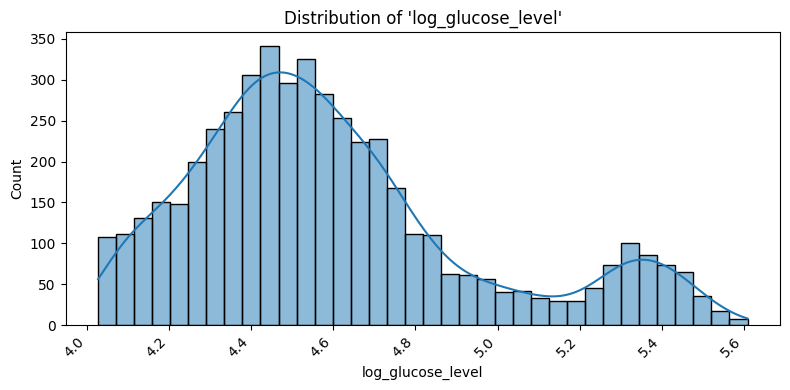

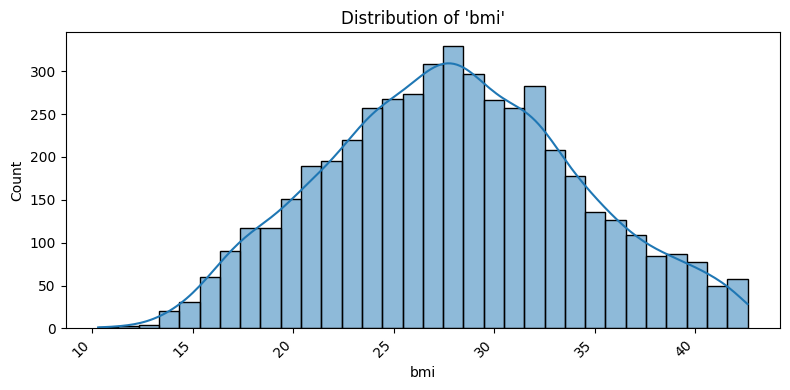

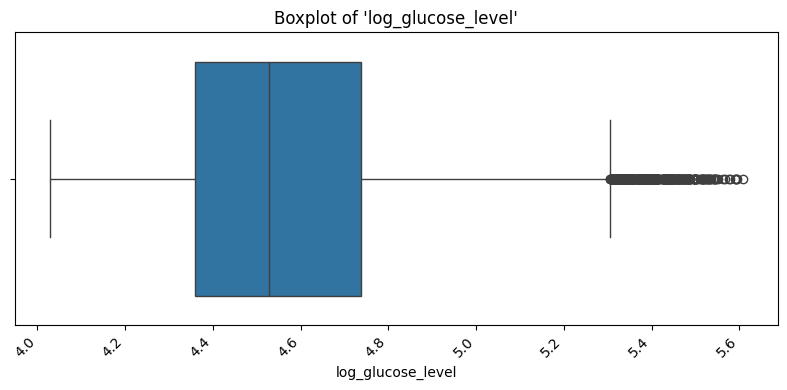

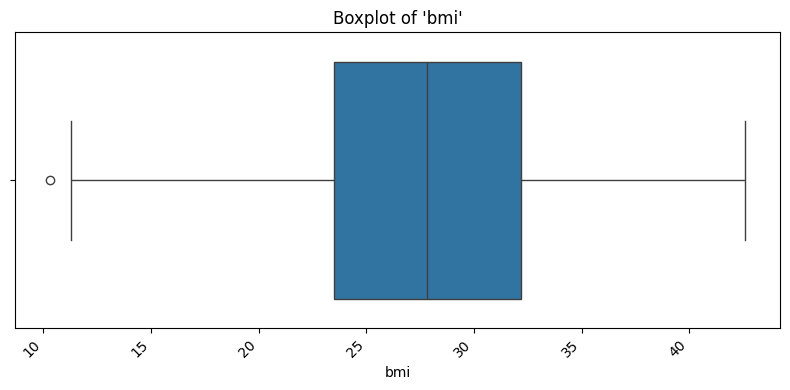

In [6]:
import numpy as np

# Let's drop outliers 95th percentile
bmi_95th = df['bmi'].quantile(0.95)
df = df[(df['bmi'] <= bmi_95th)]

# Apply log transform left skewed distribution
df['log_glucose_level'] = np.log1p(df["avg_glucose_level"])

cols = ['log_glucose_level', 'bmi']

# Skewness check
for col in cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of '{col}'")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Boxplot check
for col in cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of '{col}'")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Feature Dependencies & Correalation

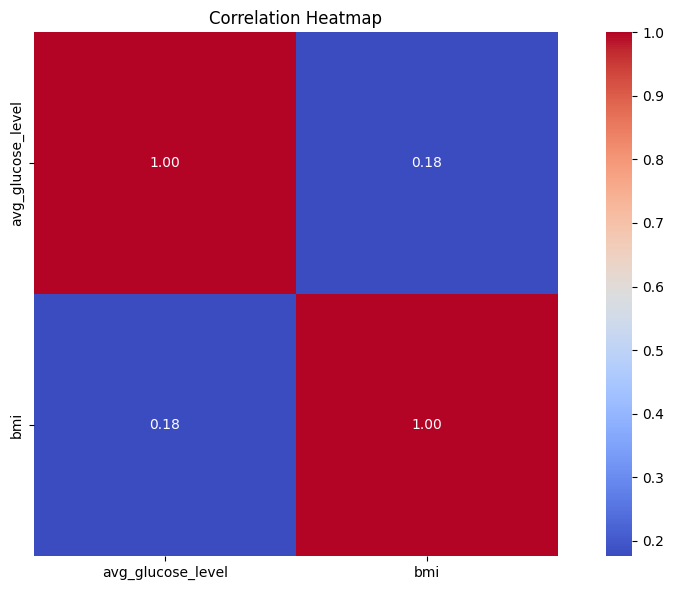

In [7]:
# Correlation heatmap
plt.figure(figsize=(10, 6))

corr = df[['avg_glucose_level', 'bmi']].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()

There is very little linear correlation between average glucose levels and BMI, which suggests that they are independent variables.

# Numerical Values Binning

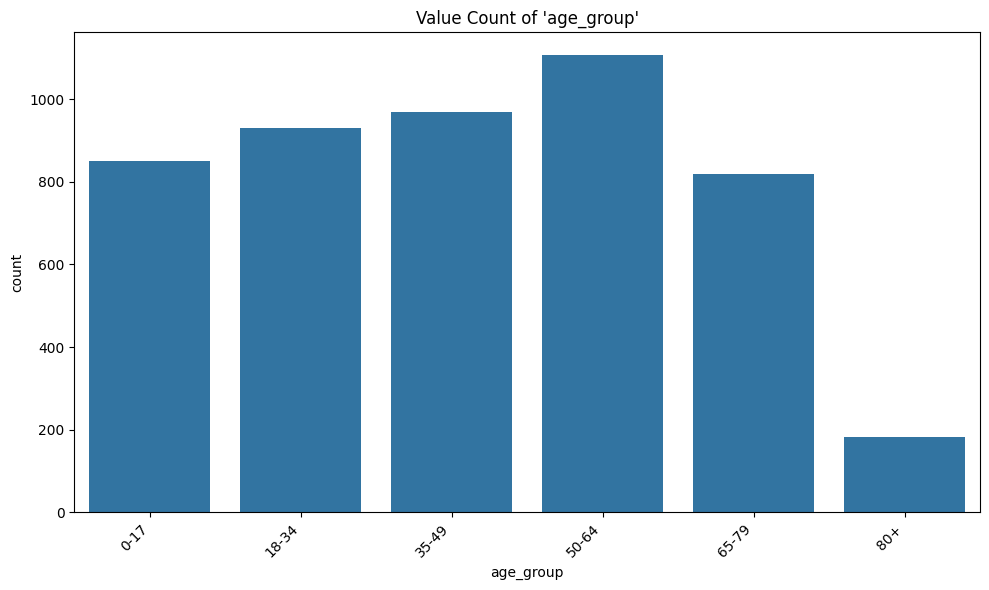

In [8]:
# Age grouping
bins = [0, 18, 35, 50, 65, 80, 120]
labels = ['0-17', '18-34', '35-49', '50-64', '65-79', '80+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_group', order=labels)
plt.title("Value Count of 'age_group'")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We apply age group binning on the age feature. This is a common practice to reduce noise and normalize the feature, making it more effective for modeling.

In [9]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 4853 entries, 0 to 5108
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             4853 non-null   object  
 1   age                4853 non-null   int32   
 2   hypertension       4853 non-null   int32   
 3   heart_disease      4853 non-null   int32   
 4   ever_married       4853 non-null   int32   
 5   work_type          4853 non-null   object  
 6   residence_type     4853 non-null   object  
 7   avg_glucose_level  4853 non-null   float64 
 8   smoking_status     4853 non-null   object  
 9   stroke             4853 non-null   int32   
 10  bmi                4853 non-null   float64 
 11  log_glucose_level  4853 non-null   float64 
 12  age_group          4853 non-null   category
dtypes: category(1), float64(3), int32(5), object(4)
memory usage: 403.1+ KB


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,smoking_status,stroke,bmi,log_glucose_level,age_group
0,Female,81,1,0,1,Private,Rural,80.43,never smoked,1,29.70,4.399744,80+
1,Male,57,0,1,0,Govt_job,Urban,217.08,Unknown,1,32.42,5.384862,50-64
3,Male,82,0,1,1,Private,Rural,208.30,Unknown,1,32.50,5.343769,80+
4,Female,72,1,0,1,Private,Rural,74.63,formerly smoked,1,23.10,4.325853,65-79
5,Male,78,0,0,1,Private,Rural,78.03,formerly smoked,1,23.90,4.369828,65-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,Female,0,0,0,0,children,Rural,62.13,Unknown,0,16.80,4.145196,0-17
5104,Male,26,0,0,0,Govt_job,Rural,100.85,smokes,0,21.00,4.623501,18-34
5105,Female,45,1,0,1,Govt_job,Rural,95.02,smokes,0,28.96,4.564557,35-49
5107,Female,13,0,0,0,children,Rural,103.08,Unknown,0,18.60,4.645160,0-17


In [10]:
# Save as gold layer

gold_bucket = "gold-data"
gold_key    = "healthcare-dataset-stroke-data"
gold_path   = f"s3a://{gold_bucket}/{gold_key}"

# Save the cleaned DataFrame to MinIO as a parquet file
df_spark = spark.createDataFrame(df)
df_spark.write.mode("overwrite").parquet(gold_path)

Now that we have the data prepared in the gold layer, we are ready to apply machine learning modeling with SageMaker. The workflow includes preprocessing with Scikit-learn pipelines, training models in SageMaker, performing hyperparameter tuning, and finally evaluating the results with post-analysis.

[**Part III: Model Training and Evaluation**](https://github.com/GiggleSamurai/aws-end-to-end-ml-pipeline/blob/main/modeling.ipynb) 👈